# Single Step ConvLSTM model

This notebook loads the Single Step ConvLSTM model for flood predictions trained [here](https://github.com/antoniomagherini99/FLOOD_group2/blob/main/models/ConvLSTM_model/multi_step_convlstm.ipynb) for testing.

It was developed for CEGM2003 DSAIE Crossover Module during 2023/2024 academic year at Delft University of Technology, Faculty of Civil Engineering and Geosciences.

In this notebook the performances and metrics of the model are shown for the first and second test datasets.

Group: FLOOD2 ([GitHub group repository](https://github.com/antoniomagherini99/FLOOD_group2)). 

Authors of the notebook:
- Lucas Terlinden-Ruhl 
\
(student number: 5863937, email: L.J.R.Terlinden-Ruhl@student.tudelft.nl)


- Antonio Magherini 
\
(student number: 5838215, email: A.Magherini@student.tudelft.nl)


<span style="color: red;">**Please note: the file path of Single Step ConvLSTM model could not be pushed as its size was larger than the 100 MB limit imposed by GitHub. Therefore it is not possible to load the file path in this notebook at the moment. The file path is can be found in the personal Google Drive at [this link](https://drive.google.com/drive/folders/1RTRliso_KVhW_aD9iFnHHpvnAeIssdYv?usp=drive_link) in case you wish to run this notebook locally on your computer.**</span>

In [1]:
# move to the root directory of the git
%cd ..

/workspace/FLOOD_group2


In [2]:
import joblib
import torch

import matplotlib.pyplot as plt

# Enable interactive widgets in Jupyter Notebook
%matplotlib widget

from torch.utils.data import DataLoader

from models.ConvLSTM_model.ConvLSTM_pytorch.convlstm import ConvLSTM
from models.ConvLSTM_model.train_eval import evaluation_conv_lstm
from pre_processing.encode_decode_csv import decode_from_csv
from pre_processing.normalization import * 
from post_processing.cool_animation import plot_animation
from post_processing.metrics import confusion_mat
from post_processing.plots import plot_test_loss, plot_metrics, plot_sorted

In [3]:
# model save path 
save_path = 'models/ConvLSTM_model/model_paths/conv_lstm_64hid_48lay_5ker_augmentation.pth'

Check if GPU is available.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# Loading datasets

The following lines create variables to more easily specify what we use the model for (i.e., train and validate, test with dataset 1 and so on) in the following functions.

In [5]:
test1 = 'test1'
test2 = 'test2'
test3 = 'test3'

Load data from decoder.

In [6]:
# test dataset 1
test_dataset1 = decode_from_csv(test1)

Restored inputs Shape: torch.Size([20, 1, 4, 64, 64])
Restored targets Shape: torch.Size([20, 48, 2, 64, 64])


In [7]:
# test dataset 2
test_dataset2 = decode_from_csv(test2)

Restored inputs Shape: torch.Size([21, 1, 4, 64, 64])
Restored targets Shape: torch.Size([21, 48, 2, 64, 64])


In [8]:
# test dataset 3
test_dataset3 = decode_from_csv(test3)

Restored inputs Shape: torch.Size([10, 1, 4, 128, 128])
Restored targets Shape: torch.Size([10, 120, 2, 128, 128])


# Visualizing a Test Sample

Below, a test sample from dataset 3 is visualized. The sample includes the following input data channels: terrain elevation (DEM), slope in the x and y directions, and water depth at time step 0.

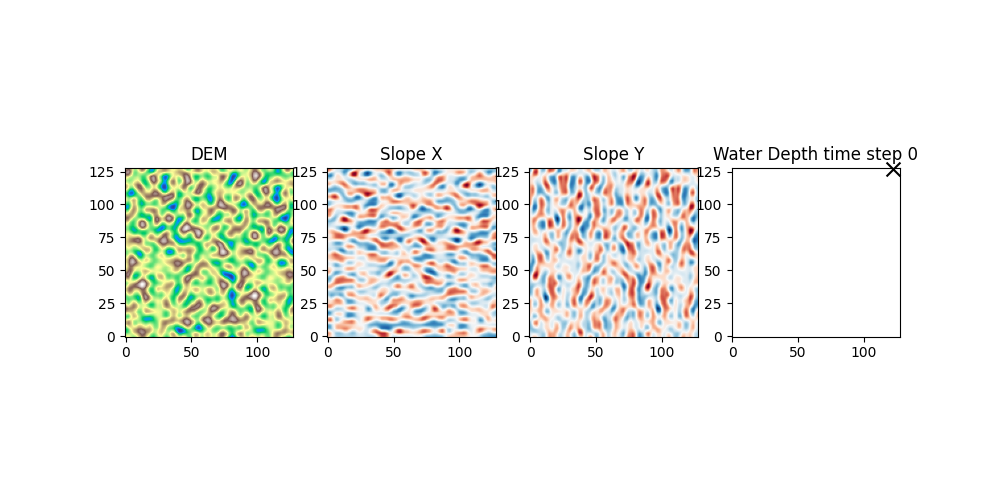

In [9]:
# From FAT application
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# specify which entry of the dataset to plot
numb = 2
input = test_dataset3[numb][0]

axs[0].imshow(input[0][0].cpu(), cmap='terrain', origin='lower')
axs[0].set_title('DEM')

axs[1].imshow(input[0][1].cpu(), cmap='RdBu', origin='lower')
axs[1].set_title('Slope X')

axs[2].imshow(input[0][2].cpu(), cmap='RdBu', origin='lower')
axs[2].set_title('Slope Y')

axs[3].imshow(input[0][3].cpu(), cmap='binary', origin='lower')
axs[3].set_title('Water Depth time step 0')

non_zero_indices = torch.nonzero(input[0, 3])
non_zero_row, non_zero_col = non_zero_indices[0][0].item(), non_zero_indices[0][1].item()
axs[3].scatter(non_zero_col, non_zero_row, color='k', marker='x', s=100,
            clip_on = False, clip_box = plt.gca().transData);

# Normalizing the Datasets

The scalers (scaler_x and scaler_y) are loaded from the directory where they were saved during training. These scalers are used to normalize the input and output data of the test datasets.

Then, the normalize_dataset function is applied to each test dataset to normalize the data

In [10]:
# Normalize the inputs and outputs using training dataset, this was done in previous notebook, only need to load the scalers
scaler_x = joblib.load('models/ConvLSTM_model/scalers/scaler_x.joblib')
scaler_y = joblib.load('models/ConvLSTM_model/scalers/scaler_y.joblib')

norm_test1 = normalize_dataset(test_dataset1, scaler_x, scaler_y, test1)
norm_test2 = normalize_dataset(test_dataset2, scaler_x, scaler_y, test2)
norm_test3 = normalize_dataset(test_dataset3, scaler_x, scaler_y, test3)

<b>Initializing MultiStepConvLSTM model</b>

Below, a MultiStepConvLSTM model is initialized. The input_dim and output_dim are set based on the shape of the normalized input and output data from the first test dataset (norm_test1). Other parameters such as hidden_dim, kernel_size, and num_layers are set according to the desired architecture.

Please refer to the '‘multistep_convlstm.py’' file within the ConvLSTM_model directory for further details on the defining of this model architecture.

In [11]:
# Model: has to be the same as in other notebook
model = ConvLSTM(input_dim = norm_test1[0][0].shape[1], 
                 output_dim = norm_test1[0][1].shape[1], 
                 hidden_dim = 64, kernel_size = (5, 5), num_layers = 48, 
                 batch_first=True, bias=True, return_all_layers = True).to(device)

The MultiStepConvLSTM model consists of a stack of 8 ConvLSTM cells, each containing a 2D convolutional layer. The final layer is a 2D convolutional layer with a kernel size of (1, 1). The model is designed for multi-step prediction tasks, where it takes sequences of input data and predicts sequences of output data. The architecture of the model is organized in a way that allows it to capture spatiotemporal dependencies in the input data.

In [12]:
model

ConvLSTM(
  (conv2): Conv2d(64, 2, kernel_size=(1, 1), stride=(1, 1))
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(68, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1-47): 47 x ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
)

# Model Evaluation on Test Datasets

<b>Create Test Dataloaders</b>

Below, the dataloaders are initialized for each normalized dataset. These dataloaders are used to iterate over the test data in batches during evaluation.

In [13]:
# Create the test dataloaders to "feed" data to the model
batch_size = 10
test1_loader = DataLoader(norm_test1, batch_size = batch_size, shuffle = False)
test2_loader = DataLoader(norm_test2, batch_size = batch_size, shuffle = False)
test3_loader = DataLoader(norm_test3, batch_size = batch_size, shuffle = False)

<b>Load Pre-trained Model</b>

The pre-trained ConvLSTM model is loaded using the load_state_dict method.

In [14]:
# load model no avoid training every time notebook is run
model.load_state_dict(torch.load(save_path, map_location = torch.device(device)))

<All keys matched successfully>

<b>Evaluate Model and Compute Metrics

Next, the model is evaluated on each test dataset using the evaluation_conv_lstm function, and confusion matrix metrics (recall, accuracy, F1 score) are computed using the confusion_mat function.

The code below uses two custom functions for evaluation purposes:

<b>evaluation_conv_lstm</b>

The 'evaluation_conv_lstm' function is used for evaluation the model. The function calculates the mean squared error (MSE) loss between the predicted and true values. It takes three input parameters:

•	model: The ConvLSTM model to be evaluated.

•	loader: The dataloader containing the test dataset.

•	device: The device (CPU or GPU) on which the evaluation should be performed.

The function then iterates through the batches in the provided dataloader. For each batch, it extracts the input sequences (x) and true labels (y). It then obtains model predictions using the obtain_predictions function (assuming it is defined elsewhere), computes the MSE loss, and appends the loss to the losses list.

<b>confusion_mat</b>

The confusion_mat function cmputes recall, accuracy, and F1 score for a given dataset, or optionally, for a specific sample within the dataset. The function uses binary classification metrics and is designed for evaluating water depth predictions. It takes the following parameters:

•	dataset: The normalized dataset (1, 2, or 3) on which to perform the evaluation.

•	model: The model used to generate predictions.

•	scaler_y: An instance of a normalizer used on the targets/outputs.

•	device: The device (CPU or GPU) on which to perform computations.

•	thresholds: Denormalized thresholds for each feature.

•	sample: A boolean indicating whether to compute metrics on the entire dataset (False) or just a sample (True).

•	sample_num: An integer indicating which sample to calculate metrics for if sample is set to True. Defaults to 0.

The function then iterates through the samples in the dataset (or a single sample if sample is True). For each sample, it obtains model predictions, computes binary predictions using the threshold_function, and calculates binary classification metrics (recall, accuracy, and F1 score) for each feature and time step. Note: In case sample is set to False (which is the default value), the function computes macro averages of the recall, accuracy, and F1 score for water depth only.

In [15]:
loss_func = 'MSE' # to be consistent with loss functions

In [16]:
test_loss = evaluation_conv_lstm(model, test1_loader, device, loss_f = loss_func)
recall1, acc1, f1_1 = confusion_mat(norm_test1, model, scaler_y, device)

In [17]:
test_loss2 = evaluation_conv_lstm(model, test2_loader, device=device, loss_f = loss_func)
recall2, acc2, f1_2 = confusion_mat(norm_test2, model, scaler_y, device)

In [19]:
print('Test ' + loss_func + ' for Water Depth and Discharge:\n'
      f'\t First test dataset: {test_loss :.4f}\n'
      f'\t Second test dataset: {test_loss2 :.4f}\n')

print(f'Average Recall for Water Depth:\n'
      f'\t First test dataset: {torch.mean(recall1) :.4f}\n'
      f'\t Second test dataset: {torch.mean(recall2) :.4f}\n')

print(f'Average F1 score for Water Depth:\n'
      f'\t First test dataset: {torch.mean(f1_1) :.4f}\n'
      f'\t Second test dataset: {torch.mean(f1_2) :.4f}\n')

print(f'Average Accuracy for Water Depth:\n'
      f'\t First test dataset: {torch.mean(acc1) :.4f}\n'
      f'\t Second test dataset: {torch.mean(acc2) :.4f}\n')

Test MSE for Water Depth and Discharge:
	 First test dataset: 0.0017
	 Second test dataset: 0.0060

Average Recall for Water Depth:
	 First test dataset: 0.6922
	 Second test dataset: 0.7222

Average F1 score for Water Depth:
	 First test dataset: 0.5641
	 Second test dataset: 0.5793

Average Accuracy for Water Depth:
	 First test dataset: 0.8606
	 Second test dataset: 0.8139



# Plotting results

The code below uses four custom function for plotting:

<b>plot_test_loss</b>

The plot_test_loss function visualizes the test loss for each sample in the specified dataset (dataset) and model. It uses the mean squared error (MSE) loss and shows the normalized loss for each sample.

<b>plot_metrics</b>

The plot_metrics function generates a scatter plot for Recall, Accuracy, and F1 score for each sample in the specified dataset. It focuses on Water Depth metrics only.

<b>plot_sorted</b>

The plot_sorted function creates a series of subplots to showcase the variation of DEMs (Digital Elevation Models) sorted in increasing order of the average loss (Water Depth and Discharge). It includes boxplots for DEM elevation, scatter plots for Water Depth and Discharge losses, and a scatter plot for Recall.

<b>plot_animation</b>

The plot_animation function creates an animated plot to visualize the evolution of certain variables over time. 

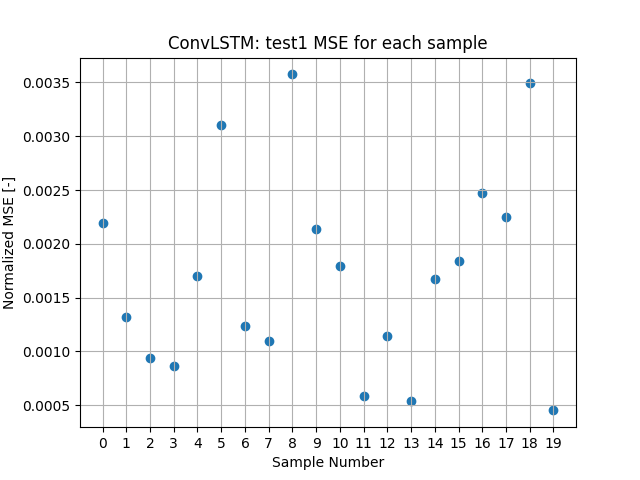

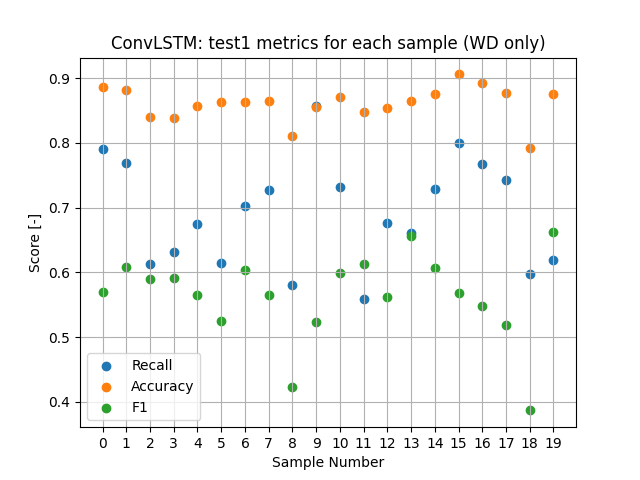

In [40]:
dataset_to_plot = norm_test1
identif = test1

plot_test_loss(dataset_to_plot, model, identif, device, loss_f = loss_func)
plot_metrics(dataset_to_plot, model, identif, scaler_y, device)

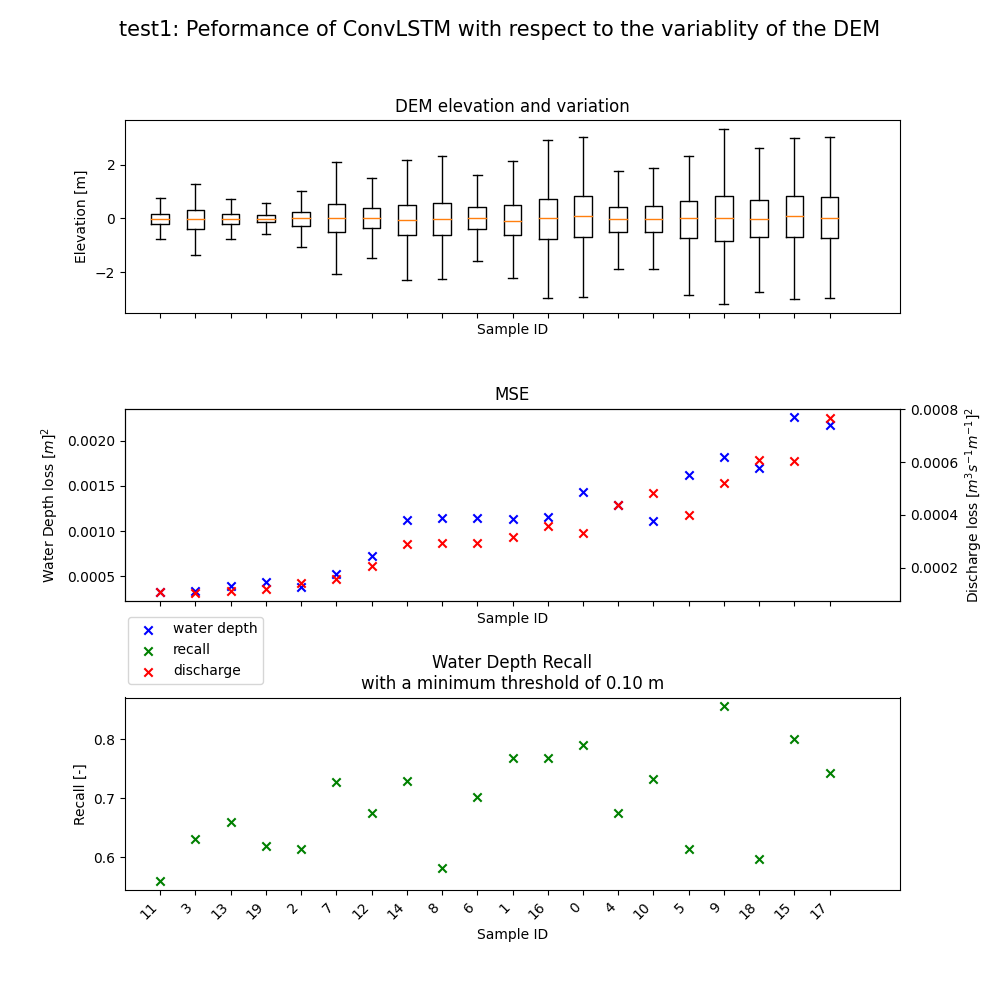

In [41]:
plot_sorted(dataset_to_plot, model, identif, scaler_x, scaler_y, device, loss_f = loss_func)

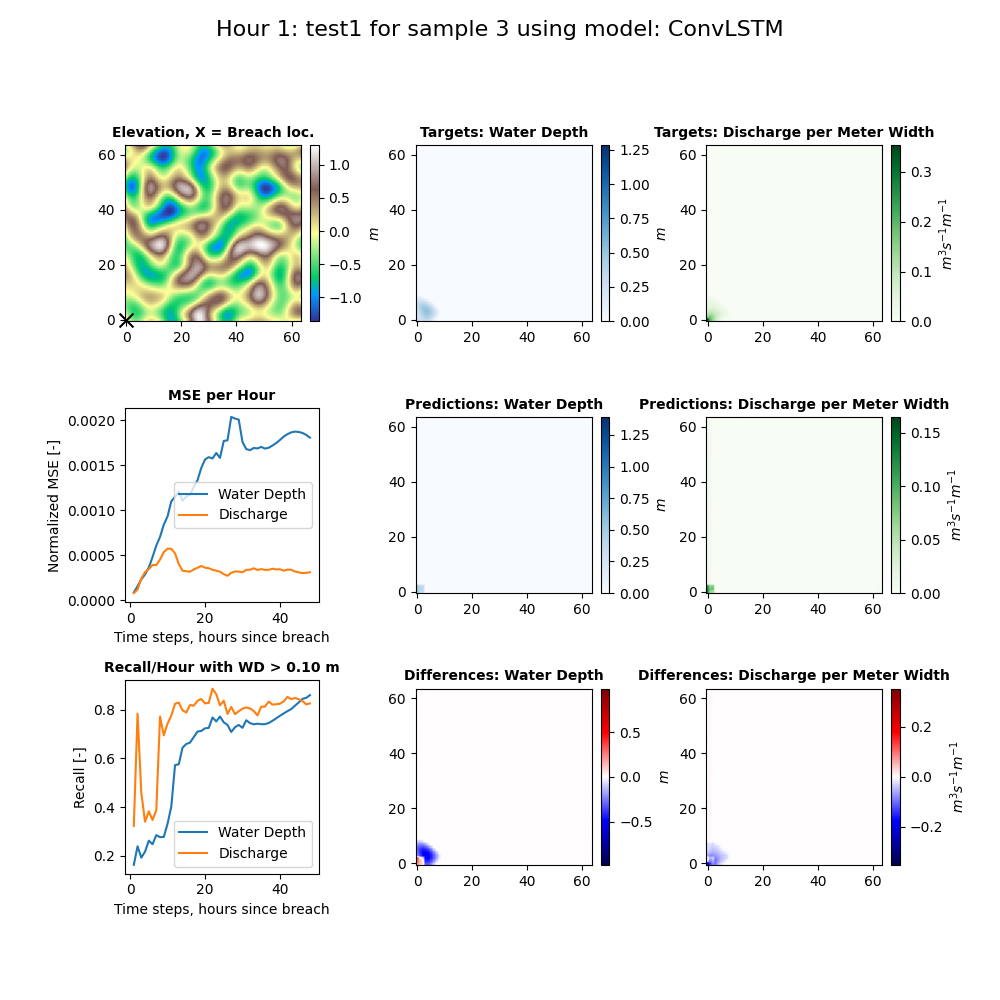

In [44]:
plot_animation(15, norm_test1, model, test1, scaler_x, scaler_y, device = device, 
               save = False, loss_f = loss_func, best_worst='worst', loss_recall='loss')